<a href="https://colab.research.google.com/github/crescendonow/thai_geoparsing/blob/main/IJG_5_bi_lstm_crf60epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

learning_rate = default,\n
drop_out = 0.3,\n
epochs = 50,\n
activation = 'softmax',\n
optimizer = 'adam',\n
unit = 64,\n
dense = n_tag(37)\n

##adam = tf.keras.optimizers.Adam(learning_rate=0.0001, <br>beta_1=0.9, beta_2=0.999, amsgead=False) <br>
references : https://arxiv.org/abs/1904.09237

In [ ]:
#Install every library for use in notebook
!pip install pickle-mixin
!pip install tqdm
!pip install pythainlp[full]

In [ ]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check GPU runtime
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 28 17:37:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#check ram usage
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
#If you want to use bi-lstm+crf ; set tf 1.xx
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

In [ ]:
# Save / Load File
import dill
import pickle

# Plot Graph
import matplotlib.pyplot as plt

# Sklearn Report
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from itertools import chain

# Load Vectors
from gensim.models import KeyedVectors

# Utility
import numpy as np
import time

# Model Utility
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

# Keras Model
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.utils import to_categorical
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [ ]:
#load train and test data
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/1.Tokennization/train_dn.data', 'rb') as token:
    train_data = pickle.load(token)
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/1.Tokennization/validate_dn.data', 'rb') as token2:
    validate_data = pickle.load(token2)   
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/1.Tokennization/test_attacut_cl.data', 'rb') as token3:
    test_data = pickle.load(token3)

In [ ]:
#load dict ner_dict, chardict
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/5.dict/ner_ix.dict', 'rb') as ner:
    ner_to_ix = pickle.load(ner)
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/5.dict/chardict.pickle', 'rb') as chardict:
    char2idx = pickle.load(chardict)

In [ ]:
#load dict word index, thai2fit dict and thai2fit index
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/5.dict/word_index.dict', 'rb') as word_index:
    word_to_ix = pickle.load(word_index)
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/5.dict/thai2index.dict', 'rb') as thai_index:
    thai2dict_to_ix = pickle.load(thai_index)
with open('/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/5.dict/thai2dict.dict', 'rb') as thai_to_dict:
    thai2dict = pickle.load(thai_to_dict)   

In [ ]:
thai2fit_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/dissertation/thai2vecNoSym.bin',binary=True)
thai2fit_weight = thai2fit_model.vectors

In [ ]:
ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_ner = dict((v,k) for k,v in ner_to_ix.items())  #convert index to ner
ix_to_thai2dict = dict((v,k) for k,v in thai2dict_to_ix.items())  #convert index to thai2fit

n_word = len(word_to_ix)
n_tag = len(ner_to_ix)
n_thai2dict = len(thai2dict_to_ix)
n_chars = len(char2idx)

print(n_word)
print(n_tag)
print(n_thai2dict)
print(ner_to_ix)

41375
38
55677
{'O': 0, 'B-ACP': 1, 'I-ACP': 2, 'B-ADMIN': 3, 'I-ADMIN': 4, 'B-BSN': 5, 'I-BSN': 6, 'B-DEP': 7, 'I-DEP': 8, 'B-FPLACE': 9, 'I-FPLACE': 10, 'B-GOV': 11, 'I-GOV': 12, 'B-HP': 13, 'I-HP': 14, 'B-MKT': 15, 'I-MKT': 16, 'B-MON': 17, 'I-MON': 18, 'B-NAT': 19, 'I-NAT': 20, 'B-OTHER': 21, 'I-OTHER': 22, 'B-RCT': 23, 'I-RCT': 24, 'B-RES': 25, 'I-RES': 26, 'B-ROAD': 27, 'I-ROAD': 28, 'B-RP': 29, 'I-RP': 30, 'B-RT': 31, 'I-RT': 32, 'B-STORE': 33, 'I-STORE': 34, 'B-TRAN': 35, 'I-TRAN': 36, 'pad': 37}


In [ ]:
#Set Parameter and Hyper Parameter
max_len = 250
max_len_char = 30

character_LSTM_unit = 32
char_embedding_dim = 32
main_lstm_unit = 256 ## Bidirectional 256 + 256 = 512
lstm_recurrent_dropout = 0.5

train_batch_size = 32
train_epochs = 60

In [ ]:
#mapping function if unkwnon from embedding use "unknown"
def prepare_sequence_word(input_text):
    idxs = list()
    for word in input_text:
        if word in thai2dict:
            idxs.append(thai2dict_to_ix[word])
        else:
            idxs.append(thai2dict_to_ix["unknown"]) #Use UNK tag for unknown word
    return idxs

def prepare_sequence_target(input_label):
    idxs = [ner_to_ix[w] for w in input_label]
    return idxs

In [ ]:
input_sent =[ [ word[0] for word in sent]for sent in train_data ] #words only
train_targets =[ [ word[2] for word in sent]for sent in train_data ] #NER only

input_val_sent =[ [ word[0] for word in sent]for sent in validate_data ] #words only
validate_targets =[ [ word[2] for word in sent]for sent in validate_data ] #NER only

input_test_sent =[ [ word[0] for word in sent]for sent in test_data ] #words only
test_targets =[ [ word[2] for word in sent]for sent in test_data ] #NER only

In [ ]:
#Prepare Training Dataset

## Word Training
X_word_tr = [prepare_sequence_word(s) for s in input_sent]
X_word_tr = pad_sequences(maxlen=max_len, sequences=X_word_tr, value=thai2dict_to_ix["pad"], padding='post', truncating='post')

## Character Training
X_char_tr = []
for sentence in train_data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))
        sent_seq.append(word_seq)
    X_char_tr.append(np.array(sent_seq))

## Sequence Label Training
y_tr = [prepare_sequence_target(s) for s in train_targets]
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, value=ner_to_ix["pad"], padding='post', truncating='post')
y_tr = [to_categorical(i, num_classes=n_tag) for i in y_tr]

In [ ]:
#Prepare Validate Dataset
## Word validattion
X_word_va = [prepare_sequence_word(s) for s in input_val_sent]
X_word_va = pad_sequences(maxlen=max_len, sequences=X_word_va, value=thai2dict_to_ix["pad"], padding='post', truncating='post')

## Character Training
X_char_va = []
for sentence in validate_data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))
        sent_seq.append(word_seq)
    X_char_va.append(np.array(sent_seq))

## Sequence Label Training
y_va = [prepare_sequence_target(s) for s in validate_targets]
y_va = pad_sequences(maxlen=max_len, sequences=y_va, value=ner_to_ix["pad"], padding='post', truncating='post')
y_va = [to_categorical(i, num_classes=n_tag) for i in y_va]

In [ ]:
#Prepare Testing Dataset

## Word Testing
X_word_te = [prepare_sequence_word(s) for s in input_test_sent]
X_word_te = pad_sequences(maxlen=max_len, sequences=X_word_te, value=thai2dict_to_ix["pad"], padding='post', truncating='post')

## Character Testing
X_char_te = []
for sentence in test_data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))    
        sent_seq.append(word_seq)
    X_char_te.append(np.array(sent_seq))

## Sequence Label Testing
y_te = [prepare_sequence_target(s) for s in test_targets]
y_te = pad_sequences(maxlen=max_len, sequences=y_te, value=ner_to_ix["pad"], padding='post', truncating='post')
y_te = [to_categorical(i, num_classes=n_tag) for i in y_te]

In [ ]:
MODEL_PATH = f'/content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/Model_train/'

In [ ]:
#Initial Keras Model
# Word Input
word_in = Input(shape=(max_len,), name='word_input_')

# Word Embedding Using Thai2Fit
word_embeddings = Embedding(input_dim=n_thai2dict,
                            output_dim=400,
                            weights = [thai2fit_weight],input_length=max_len,
                            mask_zero=False,
                            name='word_embedding', trainable=False)(word_in)

# Character Input
char_in = Input(shape=(max_len, max_len_char,), name='char_input')

# Character Embedding
emb_char = TimeDistributed(Embedding(input_dim=n_chars, output_dim=char_embedding_dim, 
                           input_length=max_len_char, mask_zero=False))(char_in)

# Character Sequence to Vector via BiLSTM
char_enc = TimeDistributed(Bidirectional(LSTM(units=character_LSTM_unit, return_sequences=False, recurrent_dropout=lstm_recurrent_dropout)))(emb_char)


# Concatenate All Embedding
all_word_embeddings = concatenate([word_embeddings, char_enc])
all_word_embeddings = SpatialDropout1D(0.3)(all_word_embeddings)

# Main Model BiLSTM
main_lstm = Bidirectional(LSTM(units=main_lstm_unit, return_sequences=True,
                               recurrent_dropout=lstm_recurrent_dropout))(all_word_embeddings)
main_lstm = TimeDistributed(Dense(50, activation="relu"))(main_lstm)

# CRF
crf = CRF(n_tag)  # CRF layer
out = crf(main_lstm)  # output

# Model
model = Model([word_in, char_in], out)

#load save model and continue train model from last epochs
#load_filepath=MODEL_PATH+"last_weights60.hdf5"
#model.load_weights(load_filepath)
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 250, 30)      0                                            
__________________________________________________________________________________________________
word_input_ (InputLayer)        (None, 250)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 250, 30, 32)  12768       char_input[0][0]                 
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 250, 400)     22270800    word_input_[0][0]               

In [ ]:
filepath=MODEL_PATH+"weights-improvement-{epoch:02d}-{val_crf_viterbi_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_crf_viterbi_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))
                     ],
                     np.array(y_tr),
                     batch_size=train_batch_size, epochs=train_epochs, verbose=1,callbacks=callbacks_list,
                     validation_data=(
                     [X_word_va,
                     np.array(X_char_va).reshape((len(X_char_va), max_len, max_len_char))
                     ],
                     np.array(y_va))
                   )


Train on 17955 samples, validate on 4489 samples
Epoch 1/60
17955/17955 [==============================] - 405s 23ms/step - loss: 0.0385 - crf_viterbi_accuracy: 0.9927 - val_loss: 0.0118 - val_crf_viterbi_accuracy: 0.9976

Epoch 00001: val_crf_viterbi_accuracy improved from -inf to 0.99758, saving model to /content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/Model_train/weights-improvement-01-0.998.hdf5
Epoch 2/60
17955/17955 [==============================] - 403s 22ms/step - loss: 0.0113 - crf_viterbi_accuracy: 0.9974 - val_loss: 0.0082 - val_crf_viterbi_accuracy: 0.9976

Epoch 00002: val_crf_viterbi_accuracy improved from 0.99758 to 0.99762, saving model to /content/drive/MyDrive/dissertation/TEXT DATA/TrainingData/Model_train/weights-improvement-02-0.998.hdf5
Epoch 3/60
17955/17955 [==============================] - 403s 22ms/step - loss: 0.0078 - crf_viterbi_accuracy: 0.9975 - val_loss: 0.0054 - val_crf_viterbi_accuracy: 0.9977

Epoch 00003: val_crf_viterbi_accuracy improve

In [ ]:
save_filepath=MODEL_PATH+"bi-lstm-crf_last_weight-60.hdf5"
model.save_weights(save_filepath)

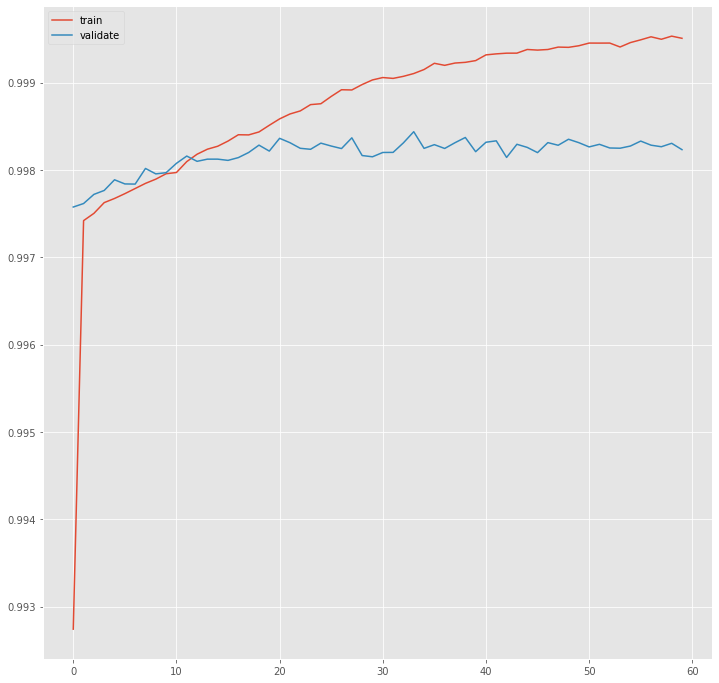

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"], label='train')
plt.plot(hist["val_crf_viterbi_accuracy"], label='validate')
plt.legend()
plt.show()

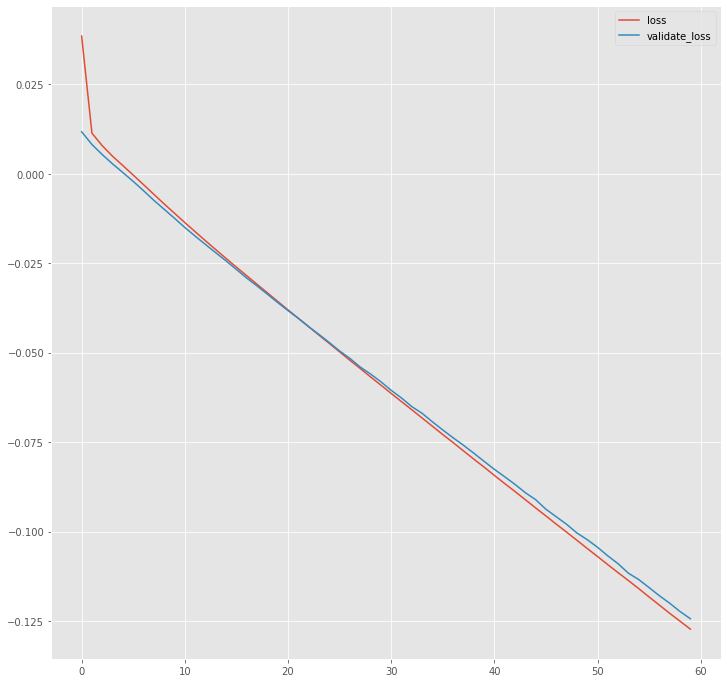

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='loss')
plt.plot(hist["val_loss"], label='validate_loss')
plt.legend()
plt.show()

In [ ]:
pred_model = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te),max_len, max_len_char))], verbose=1)

5617/5617 [==============================] - 47s 8ms/step


In [ ]:
y_pred = []
y_true = []

for i in range(0,len(pred_model)):
    try:
        out = np.argmax(pred_model[i], axis=-1)
        true = np.argmax(y_te[i], axis=-1)
        revert_pred=[ix_to_ner[i] for i in out]
        revert_true=[ix_to_ner[i] for i in true]
        y_pred.append(revert_pred)
        y_true.append(revert_true)
    except:
        print (i)

In [ ]:
def ner_classification_report(y_true, y_pred):
 
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = set(lb.classes_) - {'O', 'pad'} #{'pad'} 
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    #tagset = list(sorted(set(lb.classes_)))
    #tagset = tagset[:-2]
    print(tagset)
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
        digits=4
    )

In [ ]:
print(ner_classification_report(y_true,y_pred))

['B-ACP', 'I-ACP', 'B-ADMIN', 'I-ADMIN', 'B-BSN', 'I-BSN', 'B-DEP', 'I-DEP', 'B-FPLACE', 'I-FPLACE', 'B-GOV', 'I-GOV', 'B-HP', 'I-HP', 'B-MKT', 'I-MKT', 'B-MON', 'I-MON', 'B-NAT', 'I-NAT', 'B-OTHER', 'I-OTHER', 'B-RCT', 'I-RCT', 'B-RES', 'I-RES', 'B-ROAD', 'I-ROAD', 'B-RP', 'I-RP', 'B-RT', 'I-RT', 'B-STORE', 'I-STORE', 'B-TRAN', 'I-TRAN']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ACP     0.8378    0.8378    0.8378        37
       I-ACP     0.8627    0.8381    0.8502       105
     B-ADMIN     0.9322    0.8900    0.9106       309
     I-ADMIN     1.0000    0.8507    0.9194        67
       B-BSN     0.8400    0.8077    0.8235        26
       I-BSN     0.8971    0.7262    0.8026        84
       B-DEP     0.9062    0.8447    0.8744       103
       I-DEP     0.8750    0.7917    0.8312       168
    B-FPLACE     0.8646    0.8384    0.8513        99
    I-FPLACE     0.9545    0.7778    0.8571        27
       B-GOV     0.8095    0.6800    0.7391        25
       I-GOV     0.6017    0.7802    0.6794        91
        B-HP     0.8182    0.7500    0.7826        24
        I-HP     0.9032    0.6667    0.7671        84
       B-MKT     0.8571    1.0000    0.9231        18
       I-MKT     0.8235    1.0000    0.9032        14
       B-MON     1.0000    0.5000    0.6667         2
       I-MON     0.0000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def  chunk_extract(tag_list,sentence_id):
  """
  >>> chunk_extract(['O', 'B-PER', 'I-PER', 'B-ORG', 'O'], 1)
  [(1, 1, 3, 'PER'), (1, 3, 4, 'ORG')]
  """
  nes = []
  for i, tag in enumerate(tag_list):
    if tag[0] == 'B':
        ner_type = tag[2:]
        if i < len(tag_list)-1:  
            current = i + 1
            if tag_list[current] == 'O':
                nes.append((sentence_id,i,i, ner_type)) 
            elif tag_list[current] == 'I-{}'.format(ner_type):    
                while tag_list[current] == 'I-{}'.format(ner_type) and current < (len(tag_list)-1):
                    current += 1
                nes.append((sentence_id,i, current, ner_type))
        else:
            nes.append((sentence_id,i,i, ner_type))
  return nes

In [ ]:
sentence_id = [x for x in range(len(y_te))]

In [ ]:
chunk_test = set()
for sent,idx in tqdm(zip(y_true,sentence_id)):
    ch = chunk_extract(sent,idx)
    chunk_test.update(ch)

5617it [00:00, 50554.82it/s]


In [ ]:
chunk_pred = set()
for sent,idx in tqdm(zip(y_pred,sentence_id)):
    ch = chunk_extract(sent,idx)
    chunk_pred.update(ch)

5617it [00:00, 44649.01it/s]


In [ ]:
def evaluation_phrase(true,prediction):
    total_correct = len(true.intersection(prediction))
    total_predict = len(prediction)
    total_true = len(true)
    
    precision = total_correct/total_predict
    recall = total_correct/total_true
    f1 = (2 * precision * recall)/(precision + recall)
    
    print('total_correct:',total_correct,':','total_predict:',total_predict,':','total_true:',total_true)
    print('precision:', round(precision,3))
    print('recall:', round(recall,3))
    print('f1:', round(f1,3))
    return [round(precision,3),round(recall,3),round(f1,3)]

In [ ]:
evaluation_phrase(chunk_test,chunk_pred)

total_correct: 909 : total_predict: 1076 : total_true: 1083
precision: 0.845
recall: 0.839
f1: 0.842


[0.845, 0.839, 0.842]

In [ ]:
chunk_test = list(chunk_test)
chunk_pred = list(chunk_pred)

In [ ]:
def evaluation_phrase_type(chunk_test,chunk_pred):
    total_pred, total_true, total_correct = 0, 0, 0
    df = pd.DataFrame(columns=['PRECISION','RECALL','F1','SUPPORT'])
    ent_types = ['ACP','ADMIN','BSN','DEP','FPLACE','GOV','HP','MKT','MON','NAT','OTHER','RCT','RES','ROAD','RP','RT','STORE','TRAN']
    list_correct = []
    for ent in ent_types:
        true_set = []
        pred_set = []
        type_pred,type_true,type_correct = 0,0,0
        for tag in chunk_test:
            if tag[3] == ent:
                true_set.append(tag)
            if ent in tag:
                type_true+=1
                tag_true = set(true_set)
        for tag2 in chunk_pred:
            if tag2[3] == ent:
                pred_set.append(tag2)
            if ent in tag2:
                type_pred+=1
                tag_pred = set(pred_set)
        type_correct=len(tag_true.intersection(tag_pred))
        try:
            precision = type_correct/type_pred
        except:
            precision = 0
        recall = type_correct/type_true
        try:
            f1 = (2 * precision * recall) / (precision + recall)
        except:
            f1 = 0
        list_correct.append([type_true,type_pred,type_correct,ent])
        df.loc[ent] = [round(precision,3), round(recall,3), round(f1,3), str(type_true)]

    #Calculate micro macro f1
    total_true,total_pred,total_correct = 0,0,0
    for p in list_correct:
        total_true+=p[0]
        total_pred+=p[1]
        total_correct+=p[2]
    precision_micro = total_correct / total_pred
    recall_micro = total_correct / total_true
    f1_micro = (2 * precision_micro * recall_micro) / (precision_micro + recall_micro)
    df.loc['MACRO'] = [round(df.PRECISION.mean(),3), round(df.RECALL.mean(),3), round(df.F1.mean(),3), str(total_true)]
    df.loc['MICRO'] = [round(precision_micro,3), round(recall_micro,3), round(f1_micro,3), str(total_true)]

    print(df)

In [ ]:
evaluation_phrase_type(chunk_test,chunk_pred)

        PRECISION  RECALL     F1 SUPPORT
ACP         0.800   0.778  0.789      36
ADMIN       0.932   0.896  0.914     289
BSN         0.792   0.760  0.776      25
DEP         0.849   0.790  0.819     100
FPLACE      0.879   0.851  0.865      94
GOV         0.762   0.640  0.696      25
HP          0.727   0.667  0.696      24
MKT         0.857   1.000  0.923      18
MON         1.000   0.500  0.667       2
NAT         0.900   0.818  0.857      11
OTHER       1.000   1.000  1.000       2
RCT         0.767   0.750  0.759      44
RES         0.867   0.867  0.867      30
ROAD        0.826   0.883  0.853     145
RP          0.878   0.896  0.887      48
RT          0.788   0.806  0.797     129
STORE       0.500   0.783  0.610      23
TRAN        0.909   0.789  0.845      38
MACRO       0.835   0.804  0.812    1083
MICRO       0.845   0.839  0.842    1083


In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall